In [1]:
dataset_name = "W14_comb"
df_list = ["BES_Panel","BES_reduced_with_na"]#,"BESnumeric"]

In [2]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
import pickle, os, gc, re

from IPython.display import display

import Jupyter_module_loader
from utility import *

# you should clone this git to a subdirectory called 'BES_analysis_code' (in some directory - I call it BES_analysis - doesn't matter though)
%matplotlib inline
encoding = "ISO-8859-1"

(BES_code_folder, BES_small_data_files, BES_data_folder,
 BES_output_folder, BES_file_manifest, BES_R_data_files) = setup_directories()


global BES_Panel, BES_numeric, BES_reduced, BES_reduced_with_na, BES_non_numeric
data_subfolder = BES_data_folder + dataset_name + os.sep

(manifest, dataset_filename, dataset_description, dataset_citation,
 dataset_start, dataset_stop, dataset_wave) = get_manifest(dataset_name, BES_file_manifest)

for df in df_list:
    if df=="BES_Panel":
        globals()[df]  = pd.read_msgpack(data_subfolder + dataset_filename.replace('.dta','.msgpack'))

    else:
        globals()[df]  = pd.read_msgpack(data_subfolder + df + '.msgpack' )
        globals()[df].replace(-1,np.nan,inplace=True)

(var_type, cat_dictionary, new_old_col_names, old_new_col_names) = get_small_files(data_subfolder, encoding)

var_type (5692, 13)


In [3]:
memory_use(locs = locals().items())

           BES_reduced_with_na:   1.9GiB
                     BES_Panel: 506.4MiB
                      var_type:   4.3MiB
             new_old_col_names: 288.1KiB
                cat_dictionary: 144.1KiB
             old_new_col_names: 144.1KiB
             BES_file_manifest:  42.4KiB
                      manifest:   1.7KiB
                            _i:   1.2KiB
                           _i2:   1.2KiB


In [4]:
max_wave, num_to_wave, num_to_weight, weights = get_weights(dataset_name,BES_Panel)

In [5]:
def get_all_weights(mask):

    wts = BES_Panel[list(num_to_weight.values())][mask]
    # wts.hist(bins=100,figsize=(16,12));

    wts = wts/wts.mean()
    # wts.mean(axis=1).hist(bins=100,figsize=(16,12));
    # # wts = wts/wts.mean(axis=1)
    wts = wts.mean(axis=1)
    wts =wts/wts.mean()
    return wts
# wts

In [13]:
treatment = "Housing Tenure by EuRef2016 Vote"
output_subfolder = create_subdir(BES_output_folder, treatment)

Warning, filename truncated because it was over 30. Filenames may no longer be unique


In [17]:
mask = BES_Panel["profile_eurefvote"].notnull()&BES_Panel["profile_house_tenure"].notnull()
ct = pd.crosstab( BES_Panel["profile_eurefvote"], BES_Panel["profile_house_tenure"],
                  values= get_all_weights(mask), aggfunc=sum, normalize='columns')*100

In [18]:
sorted_labels = list(BES_Panel["profile_house_tenure"].value_counts().index)

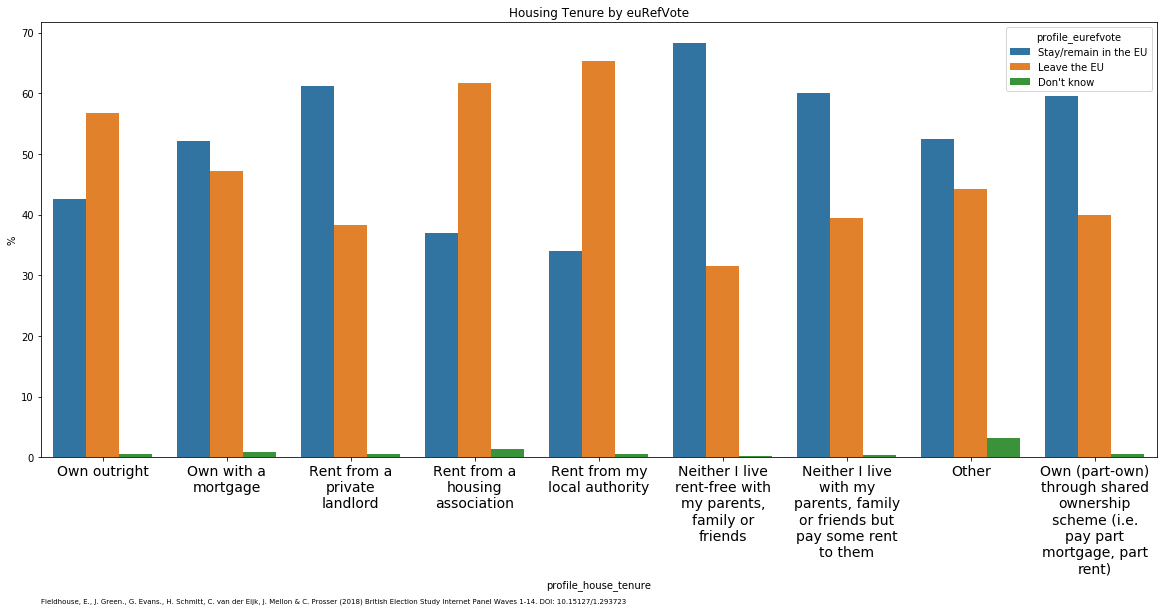

In [19]:

import textwrap 
  
wrapper = textwrap.TextWrapper(width=15) 

stacked = ct.stack().reset_index().rename(columns={0:'%'})
fig = plt.figure(figsize=(20, 8))
ax = fig.subplots()

sns.barplot(x=stacked["profile_house_tenure"],
            y=stacked['%'],
            hue=stacked["profile_eurefvote"],
            ax=ax, order = sorted_labels);
# plt.xticks(rotation=90);
# ax = plt.gca()

# labels = stacked["profile_house_tenure"].cat.categories
title = "Housing Tenure by euRefVote"
plt.title(title)
ax.set_xticklabels([ wrapper.fill(text=x) for x in sorted_labels], rotation=0, fontsize=14);

ax.annotate(dataset_citation, (0,0), (0, -140),
                 xycoords='axes fraction', textcoords='offset points', va='top', fontsize = 7) ;           
fname = output_subfolder + title.replace(" ","_") + ".png"
fig.savefig( fname, bbox_inches='tight' )

In [20]:
mask.sum()

36241